# Set up colab

In [5]:
!git clone https://github.com/NEWKNP/thai-stylegan2-ada-pytorch

Cloning into 'thai-stylegan2-ada-pytorch'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 66 (delta 9), reused 60 (delta 6), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [6]:
%cd thai-stylegan2-ada-pytorch

/content/thai-stylegan2-ada-pytorch


In [1]:
!pip install click requests tqdm opensimplex pyspng ninja imageio-ffmpeg==0.4.3

     |████████████████████████████████| 195 kB 5.1 MB/s 
     |████████████████████████████████| 108 kB 41.2 MB/s 
     |████████████████████████████████| 26.9 MB 1.8 MB/s 


In [8]:
pretrained_model = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/'
dataset_name = 'ffhq' #@param ["ffhq", "metfaces", "afhqcat","afhqdog", "afhqwild", "cifar10","brecahad"]
ffhq_model = pretrained_model + dataset_name + '.pkl'
out_path = '/content/thai-stylegan2-ada-pytorch/output'

# การใช้งานผ่าน script

## generate data

In [7]:
!mkdir output

parameters   
* `--network`: 'Network pickle filename'  
* `--seeds`: 'List of random seeds'  
* `--trunc`: 'Truncation psi'  
* `--class`: 'Class label (unconditional if not specified)'  
* `--noise-mode`: 'Noise mode' option=['const', 'random', 'none']  
* `--projected-w`: 'Projection result file'  
* `--outdir`: 'Where to save the output images' 

In [36]:
!python generate.py --outdir={out_path} --seeds=85,265,297,849 --network={ffhq_model}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating image for seed 85 (0/4) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 265 (1/4) ...
Generating image for seed 297 (2/4) ...
Generating image for seed 849 (3/4) ...


In [1]:
import math
def show_generated_images(imgpaths,num_col=10):
  """Show image as grid"""
  size    = 100
  num_img = len(imgpaths)
  num_row = int(math.ceil((num_img/num_col)))
  grid = Image.new("RGB", (size*num_col, size*num_row))
  for l, imgpath in enumerate(tqdm(imgpaths,total = len(imgpaths))): 
    i = l // num_col
    j = l % num_col
    img = Image.open(imgpath)
    result = img.resize((int(size), int(size)))
    grid.paste(result, (int(result.width * j), int(result.height * i)))
  return grid

In [ ]:
import glob
imgpaths = glob.glob('/content/thai-stylegan2-ada-pytorch/output/*')
show_generated_images(imgpaths,num_col=5)

## legacy model

In [ ]:
!python legacy.py \
    --source=https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-cat-config-f.pkl \
    --dest=stylegan2-cat-config-f-pytorch.pkl

# การใช้ใน python code

## generate image

In [19]:
import math
import pickle
import torch
from tqdm import tqdm
from PIL import Image, ImageDraw

In [ ]:
import dnnlib
import legacy

In [33]:
def loadGenerator(network_pkl, seed=303):
  ''' Load trained model (file.pkl)'''
  torch.manual_seed(seed)
  print('Loading networks from "%s"...' % network_pkl)
  device = torch.device('cuda') # device = torch.device('cpu')
  # Load networks.
  with dnnlib.util.open_url(network_pkl) as fp:
      G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore
  return G

def generateFromW(W, G, noise_mode='random'):
  ''' Generate image from numpy array (file.npz) '''
  device = torch.device('cuda') # device = torch.device('cpu')
  if type(W) != torch.Tensor:
    W = torch.from_numpy(W).to(device)
  if W.dim() != 3:
    W = W.unsqueeze(0)
  img = G.synthesis(W, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
  return img.resize((256,256))

In [20]:
G_model = loadGenerator(ffhq_model)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...


In [22]:
# example latent code
z = torch.randn([1, G_model.z_dim]).cuda()    # latent codes
w = G_model.mapping(z, None, truncation_psi=0.5, truncation_cutoff=8)

In [34]:
img = generateFromW(w, G_model)

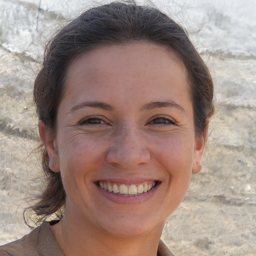

In [35]:
img

# Training data

## prepare dataset


parameters  
* `--source`: 'Directory or archive name for input dataset'  
    --source path/                      Recursively load all images from path/  
    --source dataset.zip                Recursively load all images from dataset.zip  
* `--dest`: 'Output directory or archive name for output dataset'  
    --dest /path/to/dir                 Save output files under /path/to/dir  
    --dest /path/to/dataset.zip         Save output files into /path/to/dataset.zip  
* `--max-images`: 'Output only up to `max-images` images'  
* `--resize-filter`: 'Filter to use when resizing images for output resolution'  option:['box', 'lanczos']  
* `--transform`: 'Input crop/resize mode' option=['center-crop', 'center-crop-wide']  
* `--width`: 'Output width'  
* `--height`: 'Output height' 

In [ ]:
#!python dataset_tool.py --source=/your_data --dest=~/datasets/ffhq.zip

## traing dataset

In this example, the results are saved to a newly created directory `~/training-runs/<ID>-mydataset-auto1`, controlled by `--outdir`. The training exports network pickles (`network-snapshot-<INT>.pkl`) and example images (`fakes<INT>.png`) at regular intervals (controlled by `--snap`). For each pickle, it also evaluates FID (controlled by `--metrics`) and logs the resulting scores in `metric-fid50k_full.jsonl` (as well as TFEvents if TensorBoard is installed).


The name of the output directory reflects the training configuration. For example, `00000-mydataset-auto1` indicates that the *base configuration* was `auto1`, meaning that the hyperparameters were selected automatically for training on one GPU. The base configuration is controlled by `--cfg`:

| Base config           | Description
| :-------------------- | :----------
| `auto`&nbsp;(default) | Automatically select reasonable defaults based on resolution and GPU count. Serves as a good starting point for new datasets but does not necessarily lead to optimal results.
| `stylegan2`           | Reproduce results for StyleGAN2 config F at 1024x1024 using 1, 2, 4, or 8 GPUs.
| `paper256`            | Reproduce results for FFHQ and LSUN Cat at 256x256 using 1, 2, 4, or 8 GPUs.
| `paper512`            | Reproduce results for BreCaHAD and AFHQ at 512x512 using 1, 2, 4, or 8 GPUs.
| `paper1024`           | Reproduce results for MetFaces at 1024x1024 using 1, 2, 4, or 8 GPUs.
| `cifar`               | Reproduce results for CIFAR-10 (tuned configuration) using 1 or 2 GPUs.

The training configuration can be further customized with additional command line options:
* `--aug=noaug` disables ADA.
* `--cond=1` enables class-conditional training (requires a dataset with labels).
* `--mirror=1` amplifies the dataset with x-flips. Often beneficial, even with ADA.
* `--resume=ffhq1024 --snap=10` performs transfer learning from FFHQ trained at 1024x1024.
* `--resume=~/training-runs/<NAME>/network-snapshot-<INT>.pkl` resumes a previous training run.
* `--gamma=10` overrides R1 gamma. We recommend trying a couple of different values for each new dataset.
* `--aug=ada --target=0.7` adjusts ADA target value (default: 0.6).
* `--augpipe=blit` enables pixel blitting but disables all other augmentations.
* `--augpipe=bgcfnc` enables all available augmentations (blit, geom, color, filter, noise, cutout).

In [ ]:
!python train.py --outdir=~/training-runs --data=~/mydataset.zip --gpus=1 --dry-run

In [ ]:
#!python train.py --outdir=~/training-runs --data=~/mydataset.zip --gpus=1